### Shell commands

Activate virtual environment with bash

```
cd flowers_classifier
python3 -m venv venv
. venv/bin/activate
pip install requirements.txt
```

Untar flowers data

```
tar -xf flowers.tar.gz
```

In [11]:
# Import modules

from collections import OrderedDict
import json

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from PIL import Image
import torch
from torch import nn
from torch import optim
from torchvision import datasets, transforms, models
import torch.nn.functional as F
from torch.optim import lr_scheduler
from torch.autograd import Variable

In [12]:
# Jupyter configuration

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [13]:
# Set names

data_dir = 'flowers'
train_dir = data_dir + '/train'
valid_dir = data_dir + '/valid'
test_dir = data_dir + '/test'

In [14]:
# Define transforms for training, validation, and testing datasets

data_transforms = {
    'train' : transforms.Compose([transforms.RandomResizedCrop(224),
                                    transforms.RandomHorizontalFlip(),transforms.RandomRotation(30),
                                    transforms.ToTensor(),
                                    transforms.Normalize([0.485, 0.456, 0.406], 
                                                         [0.229, 0.224, 0.225])]),
                                                            
    'valid' : transforms.Compose([transforms.Resize(256),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406], 
                                                           [0.229, 0.224, 0.225])]),

    'test' : transforms.Compose([transforms.Resize(256),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406], 
                                                           [0.229, 0.224, 0.225])])
}

In [15]:
# Load and transform datasets

image_datasets = {
    'train' : datasets.ImageFolder(train_dir, transform=data_transforms['train']),
    'test' : datasets.ImageFolder(test_dir, transform=data_transforms['test']),
    'valid' : datasets.ImageFolder(valid_dir, transform=data_transforms['valid'])
}

In [16]:
# Define data loaders

dataloaders = {
    'train' : torch.utils.data.DataLoader(image_datasets['train'], batch_size=64, shuffle=True),
    'test' : torch.utils.data.DataLoader(image_datasets['test'], batch_size=64, shuffle=False),
    'valid' : torch.utils.data.DataLoader(image_datasets['valid'], batch_size=64, shuffle=True)
}

In [17]:
# Define class to index mapping for training dataset

## key = directory
## value = index of directory

class_to_idx = image_datasets['train'].class_to_idx
idx_to_class = {v: k for k, v in class_to_idx.items()}

In [18]:
# Load mapping for label to name from json

with open('class_to_name.json', 'r') as f:
    class_to_name = json.load(f)

In [19]:
# Test class_to_idx mapping

class_ = '34'  # should be pink primrose

print(f'''
Class Directory: {class_}
Class Index: {class_to_idx[class_]}
Class Name: {class_to_name[class_]}
''')


Class Directory: 34
Class Index: 30
Class Name: mexican aster



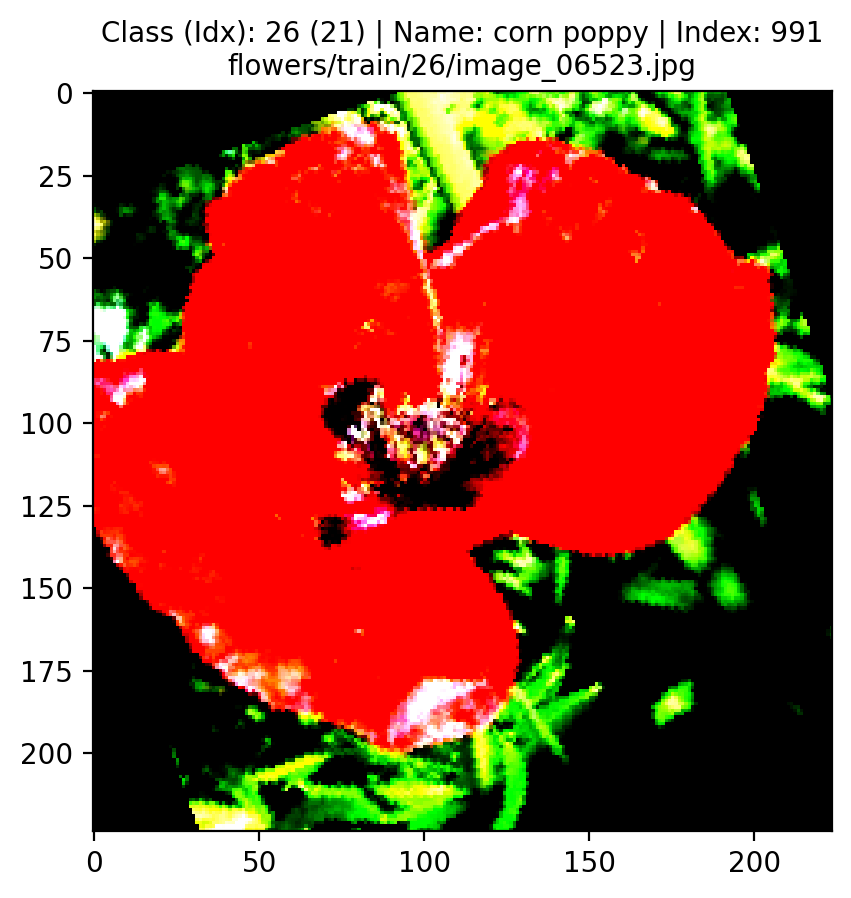

{'class': '26', 'class_index': 21, 'class_name': 'corn poppy', 'image_path': 'flowers/train/26/image_06523.jpg', 'image_index': 991}


In [36]:
# Test mapping by image index or random image

from image_utils import inspect_image

image_metadata = inspect_image(
    dataset_name='train',
    dataloaders=dataloaders,
    class_to_idx=class_to_idx,
    class_to_name=class_to_name,
    # image_idx=255  # optional
    plot=True
)

print(image_metadata)

In [22]:
# Define model

import torch.nn as nn

# Simple Neural Network
class SimpleNN(nn.Module):
    def __init__(self, input_size, num_classes):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(input_size, 512)
        self.fc2 = nn.Linear(512, num_classes)
        self.relu = nn.ReLU()
        
    def forward(self, x):
        x = x.view(x.size(0), -1)  # Flatten the input
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x

input_size = 3 * 224 * 224       # Assuming 64x64 RGB images
num_classes = len(image_datasets['train'].classes)

model = SimpleNN(input_size, num_classes)
print(model)


SimpleNN(
  (fc1): Linear(in_features=150528, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=102, bias=True)
  (relu): ReLU()
)


In [23]:
# Define loss function and optimizer and train model

import torch.optim as optim

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 5
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for inputs, labels in dataloaders['train']:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)
    
    epoch_loss = running_loss / len(dataloaders['train'].dataset)
    print(f"Epoch [{epoch+1}/{num_epochs}] Loss: {epoch_loss:.4f}")


Epoch [1/5] Loss: 17.6056
Epoch [2/5] Loss: 8.8478
Epoch [3/5] Loss: 8.8098
Epoch [4/5] Loss: 8.1787
Epoch [5/5] Loss: 7.6028


In [24]:
# Evaluate model accuracy on validation set

model.eval()
correct = 0
total = 0
with torch.no_grad():
    for inputs, labels in dataloaders['valid']:
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy on validation set: {100 * correct / total}%')


Accuracy on validation set: 3.4229828850855744%


In [32]:
# Assign class_to_idx mapping to model
model.class_to_idx = image_datasets['train'].class_to_idx

In [24]:
# Save model

torch.save(model.state_dict(), 'smooth_brain_model.pth')

In [ ]:
# Load model

# def load_checkpoint(filepath):
#     checkpoint = torch.load(filepath)
#     model = models.vgg13(pretrained = False)
#     # model.state_dict = checkpoint['state_dict']
#     model.classifier = checkpoint['classifer']
#     # model.classifier = checkpoint['classifier']    # it should be this fix me later
#     model.class_to_idx = checkpoint['class_to_idx']
    
#     return model

In [25]:
# Define process image function

import torch
from torchvision import transforms
from PIL import Image

def process_image(image_path):
    ''' Scales, crops, and normalizes a PIL image for a PyTorch model,
        returns a Tensor
    '''
    
    # Define the transformations
    transform = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], 
                             [0.229, 0.224, 0.225])
    ])
    
    # Open the image and apply the transformations
    image = Image.open(image_path)
    image = transform(image)
    
    # Add batch dimension. Model expects batches as input.
    image = image.unsqueeze(0)
    
    return image

In [33]:
# Test process_image()

image_path = 'flowers/train/61/image_06282.jpg'
process_image(image_path)

tensor([[[[-1.2103, -1.3130, -1.3815,  ...,  0.2967,  0.2453,  0.2282],
          [-1.2274, -1.2959, -1.3815,  ...,  0.2624,  0.2282,  0.2796],
          [-1.2788, -1.3302, -1.3815,  ...,  0.2453,  0.2624,  0.3481],
          ...,
          [ 0.3138,  0.1597,  0.1768,  ..., -1.1075, -1.1075, -1.1247],
          [ 0.2796,  0.1426,  0.1254,  ..., -1.0904, -1.0904, -1.1075],
          [ 0.2624,  0.1254,  0.0569,  ..., -1.0904, -1.1075, -1.1075]],

         [[-1.2829, -1.3179, -1.3179,  ...,  0.7129,  0.6779,  0.6604],
          [-1.3179, -1.3179, -1.3179,  ...,  0.6954,  0.6604,  0.7129],
          [-1.3354, -1.3354, -1.3179,  ...,  0.6779,  0.6954,  0.7829],
          ...,
          [ 0.7479,  0.6254,  0.6429,  ..., -0.8978, -0.9153, -0.9153],
          [ 0.7479,  0.6254,  0.6254,  ..., -0.8627, -0.8803, -0.9153],
          [ 0.7479,  0.6254,  0.5553,  ..., -0.8627, -0.8978, -0.9153]],

         [[-1.4384, -1.5081, -1.5604,  ...,  0.4091,  0.3393,  0.2696],
          [-1.4733, -1.5430, -

In [34]:
def predict(image_path, model, topk=5):
    ''' Predict the class (or classes) of an image using a trained deep learning model.
    '''
    
    # Ensure model is in eval mode and turn off gradients
    model.eval()
    with torch.no_grad():
        
        # Process the image
        image_tensor = process_image(image_path)
        
        # Run image through the model
        outputs = model(image_tensor)
        
        # Get the top probabilities and labels
        probs, indices = outputs.topk(topk)
        
        # Convert probabilities and indices to lists
        probs = probs.numpy().tolist()[0]
        indices = indices.numpy().tolist()[0]
        
        # Convert indices to actual category names
        # Invert the dictionary, get the mapping from index to class
        idx_to_class = {idx: cls for cls, idx in model.class_to_idx.items()}
        
        # Get the labels from the indices
        classes = [idx_to_class[index] for index in indices]
        
        return probs, classes

In [35]:
predict(image_path=image_path, model=model)

([21.277008056640625,
  16.973289489746094,
  16.83664321899414,
  16.13250160217285,
  15.462005615234375],
 ['69', '83', '90', '99', '87'])

In [ ]:
# Sample Usage:
probs, classes = predict(image_path, model)
print(probs)
print(classes)